In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

from utils import load_data
from normalization_helpers import tokenize_and_normalize


# Text preprocessing
Load data for each autor and preprocess it.

In [25]:
folder_paths = ['mickiewicz', 'slowacki', 'sienkiewicz', "reymont"]

input_dim = 1000
hidden_dim = 512
output_size = len(folder_paths)


In [26]:
label_to_author = [(i, label) for i, label in enumerate(folder_paths)]
path_to_label = [(label, i) for i, label in enumerate(folder_paths)]
label_to_author = dict(label_to_author)
path_to_label = dict(path_to_label)
print(label_to_author)
print(path_to_label)

data_to_train = []
for folder_path in folder_paths:
    print()
    print(f"Loading data from {folder_path}")

    data = " ".join(load_data(folder_path))
    print(f"{folder_path} has {len(data)} characters")
    data_to_train.append((path_to_label[folder_path], data))


{0: 'mickiewicz', 1: 'slowacki', 2: 'sienkiewicz', 3: 'reymont'}
{'mickiewicz': 0, 'slowacki': 1, 'sienkiewicz': 2, 'reymont': 3}

Loading data from mickiewicz
data/mickiewicz/dziady.txt
data/mickiewicz/pan_tadeusz.txt
mickiewicz has 466638 characters

Loading data from slowacki
data/slowacki/kordian.txt
data/slowacki/balladyna.txt
slowacki has 302772 characters

Loading data from sienkiewicz
data/sienkiewicz/na_marne.txt
data/sienkiewicz/quo_vadis.txt
data/sienkiewicz/latarnik.txt
sienkiewicz has 373579 characters

Loading data from reymont
data/reymont/chłopi.txt
reymont has 408477 characters


## Text tokenization and normalization

The text is tokenized and normalized using the following steps:

```python
    words = remove_non_ascii(words)
    words = replace_numbers(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
```

Text is tokenized using the `nltk` library for polish language. Than the text is normalized by removing non-ascii characters, converting to lowercase, removing punctuation, replacing numbers with the word and removing polish stopwords.

In [27]:
preprocessed_data = []
for data in data_to_train:
    print(label_to_author[data[0]], len(data[1]))
    preprocessed = tokenize_and_normalize(data[1])
    print(label_to_author[data[0]], len(preprocessed))
    preprocessed_data.append((data[0], preprocessed))


mickiewicz 466638
['Adam Mickiewicz\n\nDziady.', 'Poema\nDziady, część II\n\n\nDZIADY.', 'Jest to nazwisko uroczystości obchodzonej dotąd między pospólstwem w wielu powiatach Litwy, Prus i Kurlandii, na pamiątkę dziadów, czyli w ogólności zmarłych przodków.', 'Uroczystość ta początkiem swoim zasięga czasów pogańskich i zwała się niegdyś ucztą kozła, na której przewodniczył Koźlarz, Huslar, Guślarz, razem kapłan i poeta (gęślarz).', 'W teraźniejszych czasach, ponieważ światłe duchowieństwo i właściciele usiłowali wykorzenić zwyczaj połączony z zabobonnymi praktykami i zbytkiem częstokroć nagannym, pospólstwo więc święci Dziady tajemnie w kaplicach lub pustych domach niedaleko cmentarza.', 'Zastawia się tam pospolicie uczta z rozmaitego jadła, trunków, owoców i wywołują się dusze nieboszczyków.', 'Godna uwagi, iż zwyczaj częstowania zmarłych zdaje się być wspólny wszystkim ludom pogańskim, w dawnej Grecji za czasów homerycznych, w Skandynawii, na Wschodzie i dotąd po wyspach Nowego Świat

### Creating pandas dataframes with labeled data

In [28]:

training_dataframes = []
for data in preprocessed_data:
    dictionary = {
        "text" : data[1],
        "label": np.full(len(data[1]), data[0], dtype=np.int16)
    }
    training_dataframes.append(pd.DataFrame.from_dict(dictionary))


for dataframe in training_dataframes:
    display(dataframe.head())


,text,label
0,adam mickiewicz dziady,0
1,poema dziady czesc ii dziady,0
2,jest to nazwisko uroczystosci obchodzonej dota...,0
3,uroczystosc ta poczatkiem swoim zasiega czasow...,0
4,w terazniejszych czasach poniewaz swiate ducho...,0


,text,label
0,juliusz sowacki kordian czesc pierwsza trylogi...,1
1,tak egipcjanin w liscie z aloesu obwija zwiede...,1
2,juliusza sowackiego lambro przygotowanie roku ...,1
3,ciemnosc przerwana byskawicami,1
4,czarownica czesze wosy i spiewa czarownica z g...,1


,text,label
0,henryk sienkiewicz na marne i otoz i kijow,2
1,tak mowi do siebie mody czowiek nazwiskiem joz...,2
2,serce zadrgao mu radosnie by mody dar sie do z...,2
3,buda zydowska toczya sie z wolna podskakujac n...,2
4,szwarcowi sprzykrzyo sie siedziec w niej pod p...,2


,text,label
0,wadysaw stanisaw reymont chopi czesc pierwsza ...,3
1,na wieki wiekow moja agato a dokad to wedrujec...,3
2,we swiat do ludzi dobrodzieju kochany w tyli s...,3
3,ksiadz spojrza bezwiednie w te dal i rycho prz...,3
4,a moze to ino niezgoda moze nie zaraz odrzeka ...,3


Creating one randomly shuffeled dataframe with all the data.

In [29]:
df = pd.concat(training_dataframes, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,nieprozno mowia zescie we wsi najmadrzejsza al...,3
1,ociec tyla dzisiaj sprzedaje to musza uwazac k...,3
2,na ulicy pyna jak zwykle tum ludzi kilku przec...,2
3,sam mowi ze rankami budzi sie jakby zdretwiay ...,2
4,kto kuba,3


### Vectorizing text by using TfidfVectorizer

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=input_dim, min_df= 3, max_df=0.6)
X = vectorizer.fit_transform(df["text"]).toarray()
X[2][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.14264344, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.26668419, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [31]:
y = df["label"].values
y_0 =df.where(df["label"] == 0).dropna().values
y_1 =df.where(df["label"] == 1).dropna().values
y
len(y), len(y_0), len(y_1)

(15290, 3878, 3703)

# Creating train and test splits

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape


((9174, 1000), (3058, 1000), (3058, 1000))

In [33]:
def one_hot_encode(y):
    """
     Function to one hot encode the labels
    """
    y_encoded = np.zeros((len(y), len(folder_paths)))
    for i, label in enumerate(y):
        y_encoded[i][label] = 1
    return y_encoded


In [34]:
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)
y_valid = one_hot_encode(y_valid)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()


In [35]:
X_train.shape, X_train.shape

(torch.Size([9174, 1000]), torch.Size([9174, 1000]))

In [36]:
y_train.shape, y_train[:10]

(torch.Size([9174, 4]),
 tensor([[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]))

In [37]:
y_valid.shape, y_valid[:10]

(torch.Size([3058, 4]),
 tensor([[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]]))

In [38]:
input_size = 1000
output_size = len(folder_paths) # number of authors (classes)
hidden_size = 512

batch_size = 62

In [39]:
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
valid_dataset = CustomDataset(X_valid, y_valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [40]:
from sklearn.metrics import roc_auc_score
from IPython import display as disp


def training_loop(model, train_dataloader, valid_dataloader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_data = []
    fig, ax = plt.subplots(ncols=2, figsize=(15, 3), layout="constrained")
    fig.suptitle(f"Training progress - {model.name.value}")
    dh = disp.display(fig, display_id=True)
    acc_valid = []
    nr_of_epochs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        train_loss /= len(train_dataloader)
        loss_data.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, labels = torch.max(labels, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * valid_correct / valid_total
        valid_loss /= len(valid_dataloader)

        acc_valid.append(valid_accuracy)

        nr_of_epochs.append(epoch)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.2f}%")
        print()
        ax[0].clear()
        # ax.figure(figsize=(8, 4))
        ax[0].plot(nr_of_epochs,loss_data, label="Training loss")
        ax[0].legend()

        ax[1].clear()
        ax[1].plot(nr_of_epochs,acc_valid, label="Valid accuracy")
        ax[1].legend()
        dh.update(fig)

    plt.savefig(f"results/{model.name.value.lower()}/training_loss.png")
    model.eval()
    return model

# Models

In [41]:
from enum import Enum

class ModelType(Enum):
    LINEAR_MODEL = "LINEAR_MODEL"
    CONVOLUTIONAL_MODEL = "CONVOLUTIONAL_MODEL"
    LOGISTIC_REGRESSION = "LOGISTIC_REGRESSION"
    RANDOM_FOREST = "RANDOM_FOREST"

In [42]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.name = ModelType.LINEAR_MODEL
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

    def train_model(self, train_loader, valid_loader, epochs, lr):
        training_loop(self, train_loader, valid_loader, epochs, lr)


class ConvolutionalNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(ConvolutionalNet, self).__init__()
        self.name = ModelType.CONVOLUTIONAL_MODEL
        self.conv1 = nn.Conv1d(input_dim, hidden_size, 3, padding=1)
        self.batchNorm1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, 3, padding=1)
        self.batchNorm2 = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, output_dim)
        self.softMax = nn.Softmax()

    def forward(self, X):
        X = X.squeeze(0)
        X = X.T
        out = self.conv1(X)
        out = out.T
        out = self.batchNorm1(out)
        out = out.T
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.T
        out = self.batchNorm2(out)
        out = out.T
        out = self.dropout(out)
        out = self.fc1(out.T)
        out = self.fc2(out)
        out = self.softMax(out)
        return out

    def train_model(self, train_loader, valid_loader, epochs, lr):
        training_loop(self, train_loader, valid_loader, epochs, lr)


from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import  RandomForestClassifier as RFC

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.name = ModelType.LOGISTIC_REGRESSION
        self.model = LR(solver="liblinear")

    def __call__(self, X):
        return torch.tensor(self.model.predict_proba(X))

    def forward(self, X):
        return self.model(X)

    def train_model(self, X_train, y_train):
        y = np.argmax(y_train, axis=1)
        self.model.fit(X_train, y)

class RandomForest(nn.Module):
    def __init__(self):
        super(RandomForest, self).__init__()
        self.name = ModelType.RANDOM_FOREST
        self.model = RFC(criterion = 'entropy', random_state = 42, n_estimators=500, max_depth=70)

    def __call__(self, X):
        return torch.tensor(self.model.predict_proba(X))

    def forward(self, X):
        return self.model(X)

    def train_model(self, X_train, y_train):
        y = np.argmax(y_train, axis=1)
        self.model.fit(X_train, y)


In [43]:
from sklearn.metrics import classification_report
import yaml

def save_results(model: ModelType, data, results_df):
    path_to_dir = f"results/{model.value.lower()}"
    if not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)

    with open(f"{path_to_dir}/results.yml", 'w') as file:
        yaml.dump(data, file)

    results_df.to_csv(f"{path_to_dir}/test_predictions.csv")


def test_model(model, X_test, y_test):
    with torch.no_grad():
        output = model(X_test)

        output = output.numpy()
        y_test = y_test.numpy()

        print("output: ", output[:3])

        predicted = np.argmax(output, axis=1)
        y_test = np.argmax(y_test, axis=1)

        print("test values: ", y_test[:10])
        print("predicted values: ",predicted[:10])

        correct_predictions_dict = {label: 0 for label in range(len(folder_paths))}
        total_preddictions_dict = {label: 0 for label in range(len(folder_paths))}


        for label, prediction in zip(y_test, predicted):
            if label == prediction:
                correct_predictions_dict[label] += 1
            total_preddictions_dict[label] += 1

        print(correct_predictions_dict.values())
        corectly_predicted_values = sum(correct_predictions_dict.values())

        for classname, correct_count in correct_predictions_dict.items():
            accuracy = 100 * float(correct_count) / total_preddictions_dict[classname]
            print(f'Accuracy for class: {classname} - {label_to_author[classname]} is {accuracy:.1f} %')

        sk_report = classification_report(
            digits=3,
            y_true=y_test,
            y_pred=predicted)
        print(sk_report)

        roc_auc = roc_auc_score(y_test, output, multi_class="ovo")

        print("Overall metrics:")
        print(f"Accuracy: {100 * corectly_predicted_values/len(y_test):.2f}%")
        print(f"Roc auc score: {roc_auc:.3f}")

        data_to_save = {
            "accuracy": 100 * corectly_predicted_values/len(y_test),
            "roc_auc": float(roc_auc),

        }
        results_df = pd.DataFrame(
            {
                "predictions": predicted,
                "y": y_test,
            }
        )
        save_results(model.name, data_to_save, results_df)


In [44]:
models = [LogisticRegression(), RandomForest()]

for model in models:
    print(f"Training model {model.name}")
    model.train_model(X_train, y_train)
    test_model(model, X_test, y_test)


Training model ModelType.LOGISTIC_REGRESSION
output:  [[0.0082816  0.01606758 0.96086812 0.0147827 ]
 [0.38689089 0.2396831  0.2648572  0.10856881]
 [0.39147468 0.06029974 0.23848689 0.30973869]]
test values:  [2 0 3 0 3 0 2 1 0 2]
predicted values:  [2 0 0 0 3 0 2 1 3 2]
dict_values([471, 533, 591, 543])
Accuracy for class: 0 - mickiewicz is 64.8 %
Accuracy for class: 1 - slowacki is 73.1 %
Accuracy for class: 2 - sienkiewicz is 69.7 %
Accuracy for class: 3 - reymont is 72.0 %
              precision    recall  f1-score   support

           0      0.655     0.648     0.651       727
           1      0.654     0.731     0.690       729
           2      0.708     0.697     0.702       848
           3      0.788     0.720     0.753       754

    accuracy                          0.699      3058
   macro avg      0.701     0.699     0.699      3058
weighted avg      0.702     0.699     0.700      3058

Overall metrics:
Accuracy: 69.91%
Roc auc score: 0.896
Training model ModelType.RA

Training model ModelType.LINEAR_MODEL


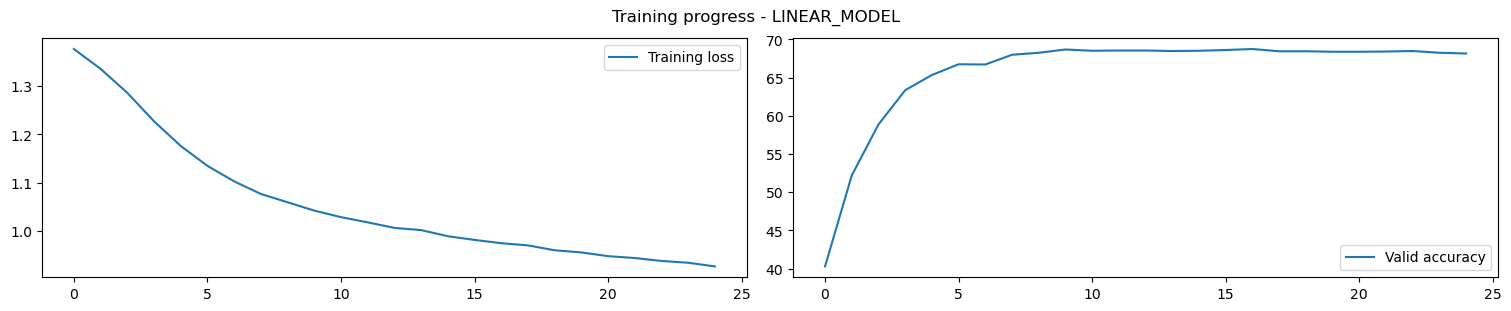

Epoch 1/25:
Train Loss: 1.3769 | Train Accuracy: 29.59%
Valid Loss: 1.3575 | Valid Accuracy: 40.29%

Epoch 2/25:
Train Loss: 1.3358 | Train Accuracy: 40.92%
Valid Loss: 1.3142 | Valid Accuracy: 52.19%

Epoch 3/25:
Train Loss: 1.2860 | Train Accuracy: 50.62%
Valid Loss: 1.2579 | Valid Accuracy: 58.86%

Epoch 4/25:
Train Loss: 1.2271 | Train Accuracy: 57.63%
Valid Loss: 1.2024 | Valid Accuracy: 63.34%

Epoch 5/25:
Train Loss: 1.1760 | Train Accuracy: 62.68%
Valid Loss: 1.1573 | Valid Accuracy: 65.34%

Epoch 6/25:
Train Loss: 1.1347 | Train Accuracy: 65.72%
Valid Loss: 1.1276 | Valid Accuracy: 66.74%

Epoch 7/25:
Train Loss: 1.1027 | Train Accuracy: 68.19%
Valid Loss: 1.1072 | Valid Accuracy: 66.71%

Epoch 8/25:
Train Loss: 1.0766 | Train Accuracy: 70.09%
Valid Loss: 1.0910 | Valid Accuracy: 67.99%

Epoch 9/25:
Train Loss: 1.0593 | Train Accuracy: 71.19%
Valid Loss: 1.0810 | Valid Accuracy: 68.25%

Epoch 10/25:
Train Loss: 1.0421 | Train Accuracy: 72.71%
Valid Loss: 1.0751 | Valid Accurac

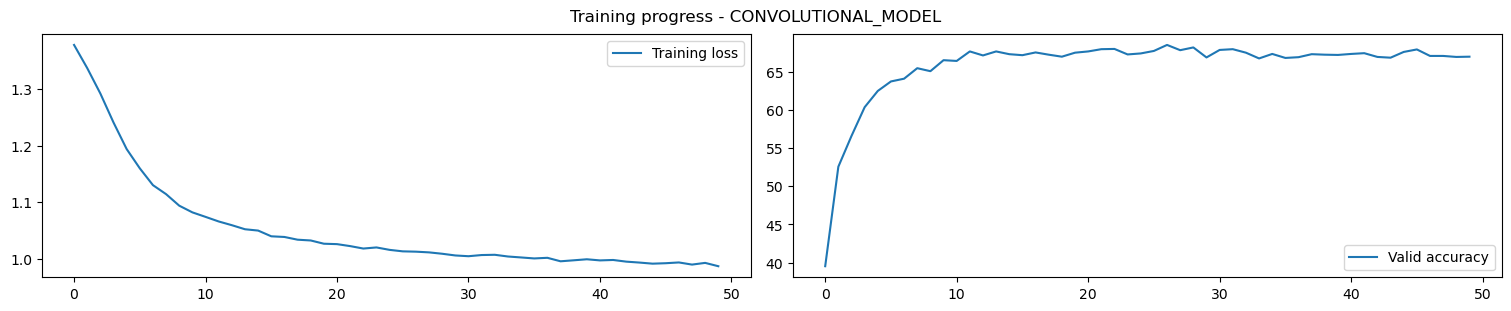

/Users/krystynawaniova/opt/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/50:
Train Loss: 1.3779 | Train Accuracy: 29.35%
Valid Loss: 1.3565 | Valid Accuracy: 39.54%

Epoch 2/50:
Train Loss: 1.3370 | Train Accuracy: 42.06%
Valid Loss: 1.3095 | Valid Accuracy: 52.55%

Epoch 3/50:
Train Loss: 1.2920 | Train Accuracy: 50.09%
Valid Loss: 1.2620 | Valid Accuracy: 56.57%

Epoch 4/50:
Train Loss: 1.2408 | Train Accuracy: 55.33%
Valid Loss: 1.2129 | Valid Accuracy: 60.33%

Epoch 5/50:
Train Loss: 1.1938 | Train Accuracy: 58.84%
Valid Loss: 1.1749 | Valid Accuracy: 62.46%

Epoch 6/50:
Train Loss: 1.1597 | Train Accuracy: 61.61%
Valid Loss: 1.1441 | Valid Accuracy: 63.70%

Epoch 7/50:
Train Loss: 1.1300 | Train Accuracy: 63.90%
Valid Loss: 1.1241 | Valid Accuracy: 64.06%

Epoch 8/50:
Train Loss: 1.1141 | Train Accuracy: 64.80%
Valid Loss: 1.1055 | Valid Accuracy: 65.43%

Epoch 9/50:
Train Loss: 1.0937 | Train Accuracy: 66.24%
Valid Loss: 1.0988 | Valid Accuracy: 65.04%

Epoch 10/50:
Train Loss: 1.0819 | Train Accuracy: 67.38%
Valid Loss: 1.0882 | Valid Accurac

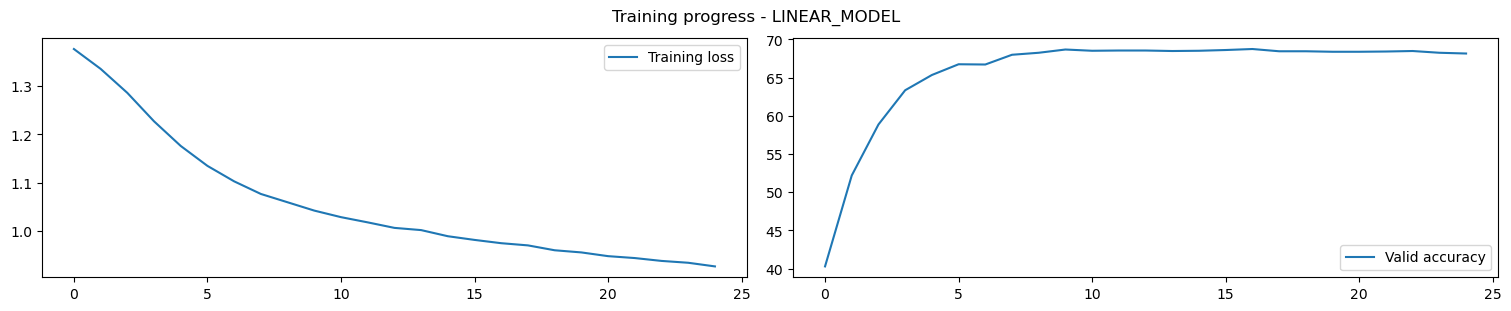

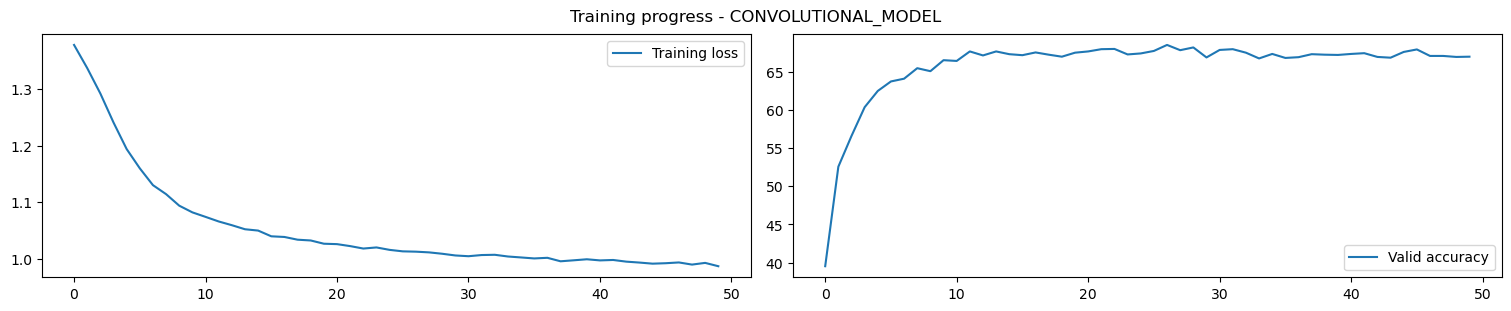

In [45]:
epochs = 25
learning_rate = 0.00003
model = Net(input_dim, 512, output_size)
print(f"Training model {model.name}")

model.train_model(train_dataloader, valid_dataloader, epochs, learning_rate)

epochs = 50
learning_rate = 0.00001

model = ConvolutionalNet(input_dim, hidden_dim, output_size)
print(f"Training model {model.name}")

model.train_model(train_dataloader, valid_dataloader, epochs, learning_rate)

Results for model: logistic_regression
{'accuracy': 69.91497710922171, 'roc_auc': 0.8960910560035734}
no
Results for model: convolutional_model
{'accuracy': 69.63460730785384, 'roc_auc': 0.8645041716775387}


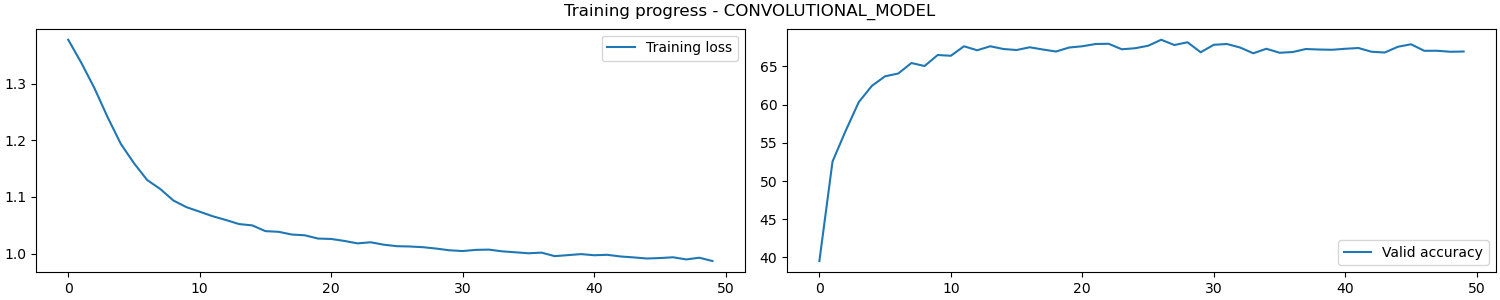

Results for model: random_forest
{'accuracy': 61.34728580771746, 'roc_auc': 0.8468230377827729}
no
Results for model: linear_model
{'accuracy': 70.93658126837464, 'roc_auc': 0.8767358895732912}


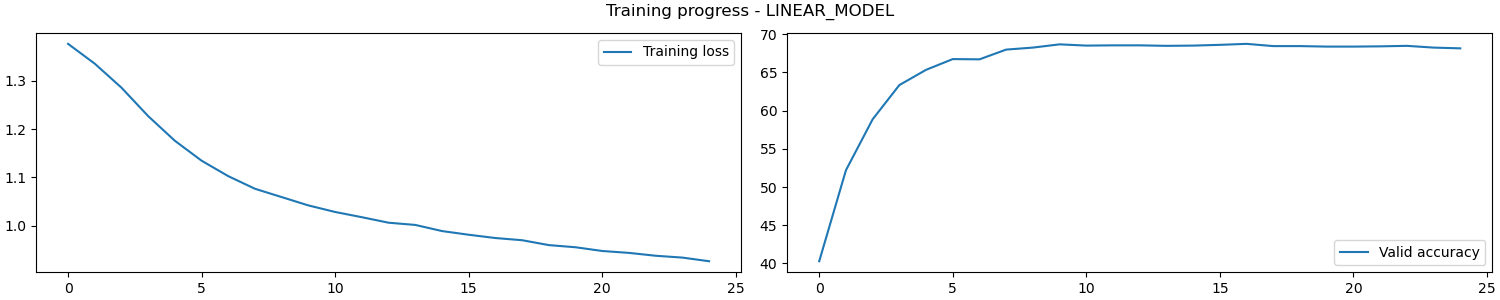

,model,accuracy,roc_auc
3,linear_model,70.936581,0.876736
0,logistic_regression,69.914977,0.896091
1,convolutional_model,69.634607,0.864504
2,random_forest,61.347286,0.846823


In [46]:
import os
from PIL import Image


folder_path = 'results'  # Specify the path to the "results" directory

accuracy = []
roc_auc = []
models = []
for folder_name in os.listdir(folder_path):
    folder_dir = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder_dir):  # Check if the item is a directory
        print(f"Results for model: {folder_name}")
        with open(f"{folder_dir}/results.yml", 'r') as file:
            data = yaml.load(file, Loader=yaml.FullLoader)
            print(data)
            models.append(folder_name)
            accuracy.append(data['accuracy'])
            roc_auc.append(data['roc_auc'])

            try:
                image = Image.open(f"{folder_dir}/training_loss.png")
                display(image)
            except FileNotFoundError:
                print("no")

df = pd.DataFrame(
    {
        "model": models,
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }
)

df.sort_values(by="accuracy", ascending=False)
